# Statistics
Let's take a look at some statistics of the data we have.

In [1]:
from collections import defaultdict

import matplotlib.pyplot as plt
import torch

from src.data.data_loading import BaseballData
from src.model.at_bat import PitchResult
from src.model.pitch_type import PitchType
from src.model.zones import ZONES_DIMENSION

bd = BaseballData.load_with_cache()

Loading baseball data... done


# Exploring Pitch Data

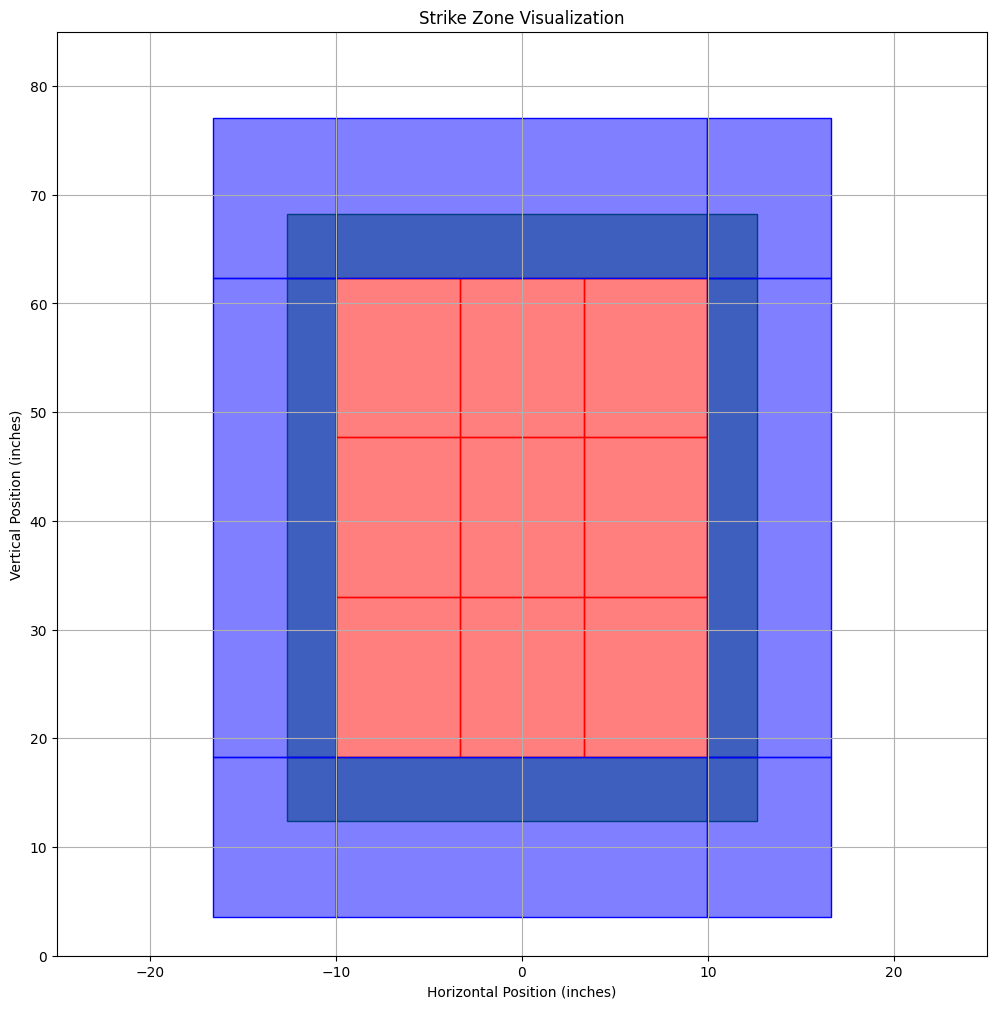

In [7]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import patches
from src.model.zones import Zone, ZONES, Inf, STRIKE_ZONE_LEFT, STRIKE_ZONE_X_STEP, STRIKE_ZONE_RIGHT, STRIKE_ZONE_TOP, STRIKE_ZONE_Y_STEP, STRIKE_ZONE_BOTTOM


def visualize_zones(zones: list[Zone]):
    """Visualizes the zones on a simple plot"""

    fig, ax = plt.subplots(figsize=(12, 12))
    for zone in zones:
        if zone.is_strike:
            edge_color = 'red'
        elif zone.is_borderline:
            edge_color = 'green'
        else:
            edge_color = 'blue'

        left = zone.left if zone.left != -Inf else STRIKE_ZONE_LEFT - STRIKE_ZONE_X_STEP
        right = zone.right if zone.right != Inf else STRIKE_ZONE_RIGHT + STRIKE_ZONE_X_STEP
        top = zone.top if zone.top != Inf else STRIKE_ZONE_TOP + STRIKE_ZONE_Y_STEP
        bottom = zone.bottom if zone.bottom != -Inf else STRIKE_ZONE_BOTTOM - STRIKE_ZONE_Y_STEP

        edge_rgb = mcolors.to_rgba(edge_color)
        face_color = edge_rgb[:3] + (0.5,)

        rect = patches.Rectangle((left, bottom), right - left, top - bottom,
                                 linewidth=1, edgecolor=edge_color, facecolor=face_color)
        ax.add_patch(rect)

    plt.xlim(-25, 25)
    plt.ylim(0, 85)
    plt.xlabel('Horizontal Position (inches)')
    plt.ylabel('Vertical Position (inches)')
    plt.title('Strike Zone Visualization')
    plt.grid(True)
    plt.show()

visualize_zones(ZONES)

In [5]:
pitch_types = torch.zeros(len(PitchType))
pitch_type_locations = defaultdict(lambda: torch.zeros(ZONES_DIMENSION, ZONES_DIMENSION))
pitch_result_locations = defaultdict(lambda: torch.zeros(ZONES_DIMENSION, ZONES_DIMENSION))
pitch_results = torch.zeros(len(PitchResult))
expected_strikes = torch.zeros(ZONES_DIMENSION, ZONES_DIMENSION)

for pitch in bd.pitches:
    for x, y in pitch.location.coords:
        pitch_type_locations[pitch.type.value][x, y] += 1
        pitch_result_locations[pitch.result.value][x, y] += 1
    pitch_types[pitch.type.value] += 1
    pitch_results[pitch.result.value] += 1
    if pitch.at_bat_state.strikes == 0 and pitch.at_bat_state.balls == 3:
        for x, y in pitch.location.coords:
            expected_strikes[x, y] += 1

In [ ]:
for pt, locs in pitch_type_locations.items():
    plt.figure()
    plt.imshow(locs, cmap='gray')
    plt.title(f'Pitch Locations for {PitchType(pt).name}')
for pr, locs in pitch_result_locations.items():
    plt.figure()
    plt.imshow(locs, cmap='gray')
    plt.title(f'Pitch Locations for {PitchResult(pr).name}')

In [ ]:
plt.bar([pr.name for pr in PitchResult], pitch_results)
plt.title('Pitch Results')

In [ ]:
plt.bar([pt.name for pt in PitchType], pitch_types)
plt.title('Pitch Types')

Text(0.5, 1.0, 'Pitches on 3-0 Count')

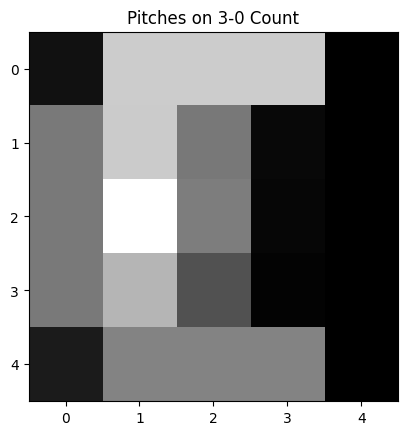

In [6]:
plt.imshow(expected_strikes, cmap='gray')
plt.title('Pitches on 3-0 Count')

# Exploring the Learned Swing Result Distribution
Let's examine the network's performance across different conditions, with known
meaningful differences.

In [2]:
from src.data.datasets import SwingResult
from typing import Callable
from src.model.pitch import Pitch
from src.data.datasets import PitchSwingDataset

test_data = PitchSwingDataset.get_random_split(bd, 0.2, seed=80)[1].pitches

conditions: dict[str, Callable[[Pitch], bool]] = {
    'all': (lambda p: True),
    '30': (lambda p: p.at_bat_state.balls == 3 and p.at_bat_state.strikes == 0),
    '02': (lambda p: p.at_bat_state.balls == 0 and p.at_bat_state.strikes == 2),
    'ball': (lambda p: not p.location.is_strike),
    'strike': (lambda p: p.location.is_strike),
    'strong pitcher vs weak batter': (lambda p: p.at_bat.pitcher.obp_percentile > 2/3 and p.at_bat.batter.obp_percentile < 1/3),
    'weak pitcher vs strong batter': (lambda p: p.at_bat.pitcher.obp_percentile < 1/3 and p.at_bat.batter.obp_percentile > 2/3),
    'strong pitcher': (lambda p: p.at_bat.pitcher.obp_percentile > 2/3),
    'weak pitcher': (lambda p: p.at_bat.pitcher.obp_percentile < 1/3),
}

matching_pitches = defaultdict(list)

actual_distribution = defaultdict(lambda: torch.zeros(len(SwingResult)))

for i in range(len(test_data)):
    for name, condition in conditions.items():
        pitch = test_data[i]
        if condition(pitch):
            matching_pitches[name].append(pitch)
            actual_distribution[name][SwingResult.from_pitch_result(pitch.result)] += 1

In [3]:
from torch.utils.data import DataLoader
from src.distributions.swing_outcome import SwingOutcome

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SwingOutcome().to(device)
path = '../../model_weights/swing_outcome, g=2.75.pth'
model.load_state_dict(torch.load(path))

predicted_distribution = defaultdict(lambda: torch.zeros(len(SwingResult)).to(device))

for condition_name, pitches in matching_pitches.items():
    dataset = PitchSwingDataset(bd, None, pitches=pitches)
    dataloader = DataLoader(dataset, batch_size=128)
    for pitch, result in dataloader:
        pitcher, batter, pitch, strikes, balls = [t.to(device) for t in pitch]
        predicted_distribution[condition_name] += model(pitcher, batter, pitch, strikes, balls).sum(dim=0)

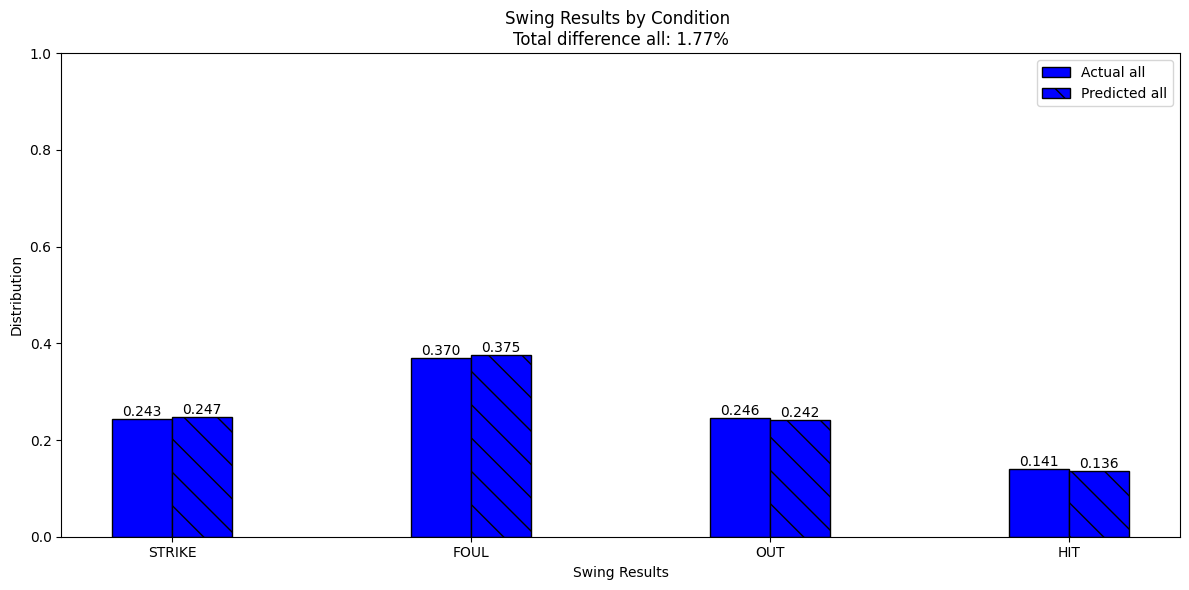

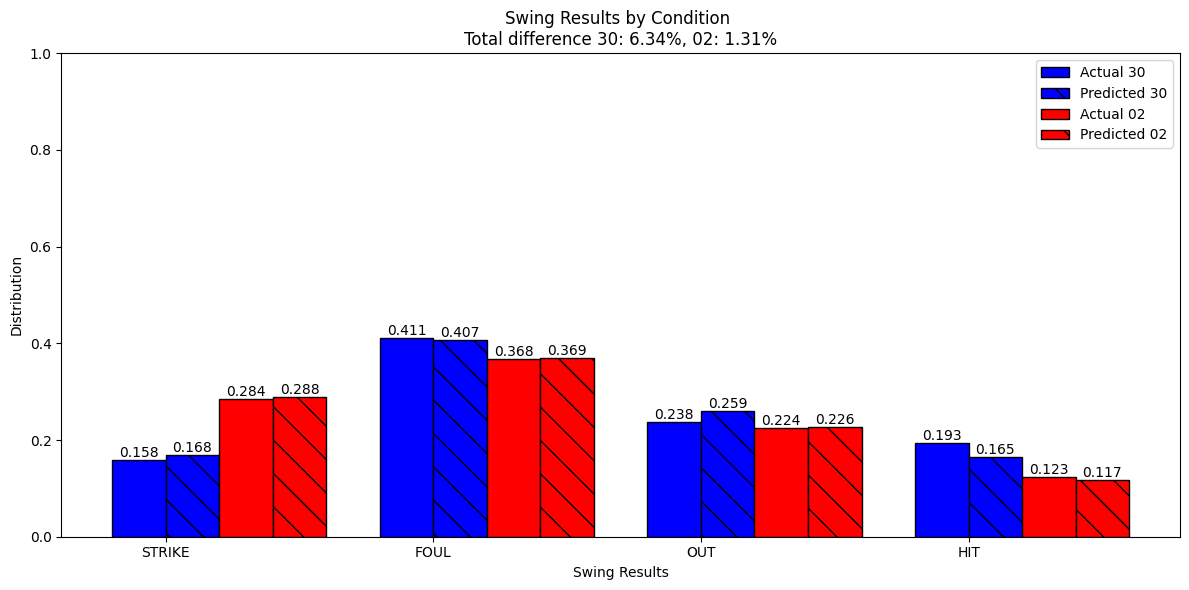

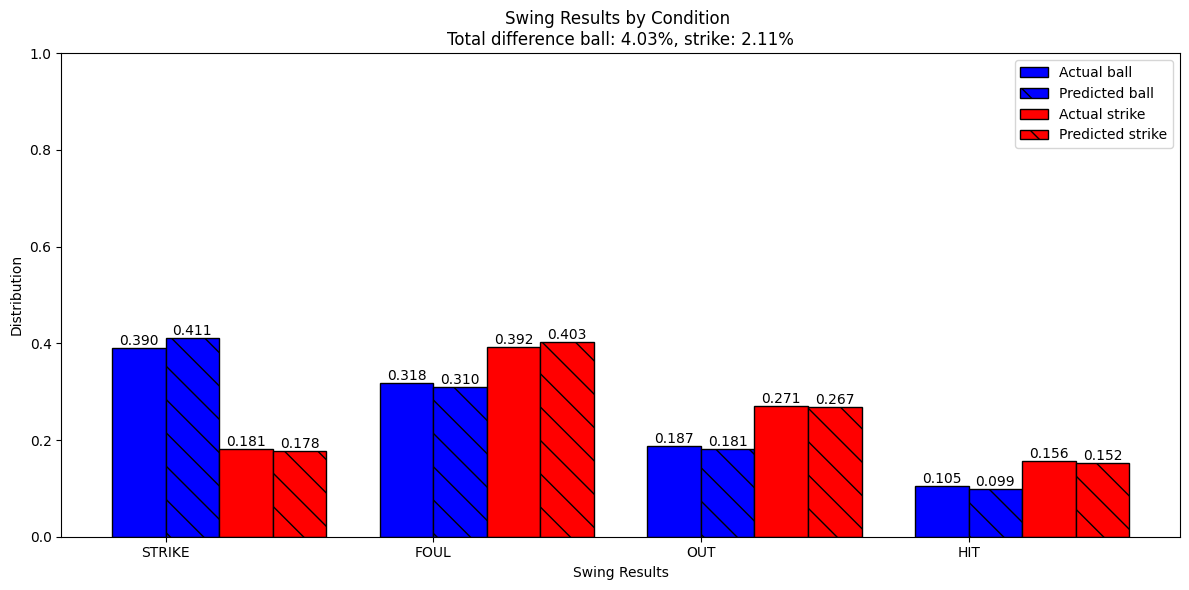

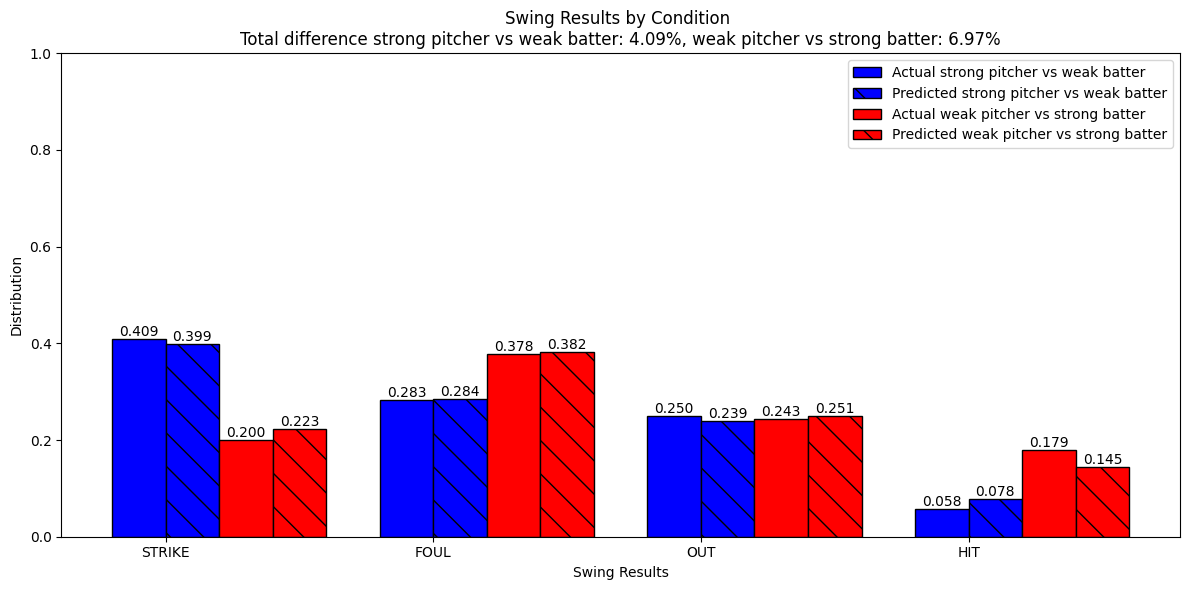

In [4]:
import numpy as np


def get_distribution(distribution: dict[str, torch.Tensor], c_name: str):
    return distribution[c_name].cpu().detach().numpy() / len(matching_pitches[c_name])

def compare_conditions(condition1: str, condition2: str = None):
    swing_results = [sr.name for sr in SwingResult]
    x = np.arange(len(swing_results))  # the label locations
    width = 0.2  # the width of the bars

    fig, ax = plt.subplots(figsize=(12, 6))

    actual_distribution_c1 = get_distribution(actual_distribution, condition1)
    predicted_distribution_c1 = get_distribution(predicted_distribution, condition1)
    
    # Plot for condition1
    bars_actual_c1 = ax.bar(x - width / 2, actual_distribution_c1, width, label=f'Actual {condition1}', color='blue', edgecolor='black')
    bars_predicted_c1 = ax.bar(x + width / 2, predicted_distribution_c1, width, label=f'Predicted {condition1}', color='blue', hatch='\\', edgecolor='black')

    if condition2:
        actual_distribution_c2 = get_distribution(actual_distribution, condition2)
        predicted_distribution_c2 = get_distribution(predicted_distribution, condition2)
        
        # Bar positions for condition 2
        bars_actual_c2 = ax.bar(x + width*1.5, actual_distribution_c2, width, label=f'Actual {condition2}', color='red', edgecolor='black')
        bars_predicted_c2 = ax.bar(x + width*2.5, predicted_distribution_c2, width, label=f'Predicted {condition2}', color='red', hatch='\\', edgecolor='black')

        # Add text labels for condition 2
        for bar in bars_actual_c2:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.3f}', ha='center', va='bottom')
        for bar in bars_predicted_c2:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.3f}', ha='center', va='bottom')

    # Add text labels for condition 1
    for bar in bars_actual_c1:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.3f}', ha='center', va='bottom')
    for bar in bars_predicted_c1:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.3f}', ha='center', va='bottom')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel('Swing Results')
    ax.set_ylabel('Distribution')
    
    error = 'Total difference %s: %.2f%%' % (condition1, 100 * sum(list(abs(actual_distribution_c1 - predicted_distribution_c1))))
    if condition2:
        error += ', %s: %.2f%%' % (condition2, 100 * sum(list(abs(actual_distribution_c2 - predicted_distribution_c2))))
    
    ax.set_title('Swing Results by Condition \n' + error)
    ax.set_xticks(x)
    ax.set_xticklabels(swing_results)
    ax.set_ylim(0, 1)
    ax.legend()

    fig.tight_layout()
    plt.show()


compare_conditions('all')
compare_conditions('30', '02')
compare_conditions('ball', 'strike')
compare_conditions('strong pitcher vs weak batter', 'weak pitcher vs strong batter')

# Exploring the Learned Pitch Control Distribution
One way to support that the model is learning meaningful features is to examine the differences predicted between better and worse pitchers (OBP). We expect better pitchers to have better control. 

One problem with this setup is that we do not have a lot of data to work with.

In [54]:
from src.distributions.pitcher_control import get_pitch_control_sets, PitcherControl

from typing import Callable

conditions: dict[str, Callable[[float], bool]] = {
    'strong pitcher': (lambda p_obp: p_obp > 2/3),
    'average pitcher': (lambda p_obp: 1/3 < p_obp < 2/3),
    'weak pitcher': (lambda p_obp: p_obp < 1/3),
}

matching_pitches = defaultdict(list)

training_set, validation_set = get_pitch_control_sets(bd)

actual_distribution = defaultdict(lambda: (0, 0))  # x, y variance
for obp, (pitcher, pitch), distribution in validation_set:
    for name, condition in conditions.items():
        if condition(obp):
            matching_pitches[name].append(((pitcher, pitch), distribution))
            actual_distribution[name] = actual_distribution[name][0] + distribution[2].item(), actual_distribution[name][1] + distribution[3].item()
            
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = PitcherControl().to(device)
model.eval()
path = '../../model_weights/pitcher_control.pth'
model.load_state_dict(torch.load(path))

predicted_distribution = defaultdict(lambda: (0, 0))

for condition_name, pitches in matching_pitches.items():
    for (pitcher, pitch), distribution in pitches:
        pitcher, pitch = pitcher.to(device).unsqueeze(0), pitch.to(device).unsqueeze(0)
        predicted_dist = model(pitcher, pitch)
        predicted_distribution[condition_name] = predicted_distribution[condition_name][0] + predicted_dist[0][2].item(), predicted_distribution[condition_name][1] + predicted_dist[0][3].item()

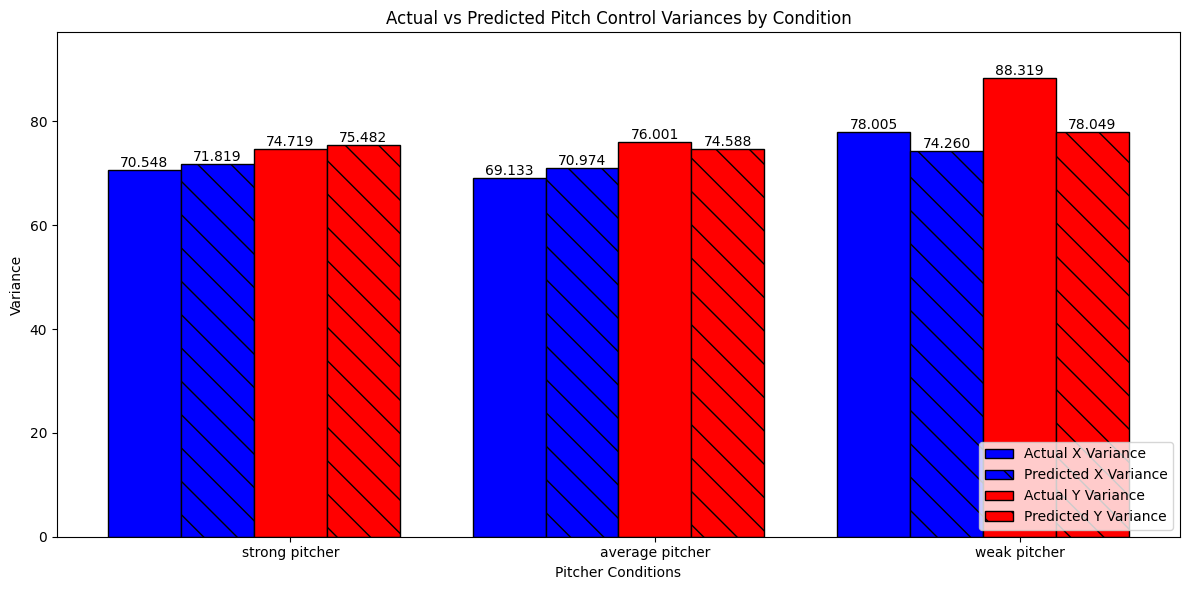

In [55]:
import numpy as np

def get_average_variance(distribution_dict, condition):
    total_x_variance, total_y_variance = distribution_dict[condition]
    num_pitches = len(matching_pitches[condition])
    if num_pitches == 0:
        return 0, 0  # Avoid division by zero if there are no matching pitches
    return total_x_variance / num_pitches, total_y_variance / num_pitches


def compare_all_conditions():
    x = np.arange(len(conditions))  # the label locations
    width = 0.2  # the width of the bars
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Get average variances for each condition
    actual_variances = [get_average_variance(actual_distribution, condition) for condition in conditions]
    predicted_variances = [get_average_variance(predicted_distribution, condition) for condition in conditions]
    
    # Separate variances for x and y
    actual_x_variances = [variance[0] for variance in actual_variances]
    actual_y_variances = [variance[1] for variance in actual_variances]
    predicted_x_variances = [variance[0] for variance in predicted_variances]
    predicted_y_variances = [variance[1] for variance in predicted_variances]
    
    # Plot actual x variances
    bars_actual_x = ax.bar(x - width, actual_x_variances, width, label='Actual X Variance', color='blue', edgecolor='black')
    # Plot predicted x variances
    bars_predicted_x = ax.bar(x, predicted_x_variances, width, label='Predicted X Variance', color='blue', hatch='\\', edgecolor='black')
    # Plot actual y variances
    bars_actual_y = ax.bar(x + width, actual_y_variances, width, label='Actual Y Variance', color='red', edgecolor='black')
    # Plot predicted y variances
    bars_predicted_y = ax.bar(x + 2 * width, predicted_y_variances, width, label='Predicted Y Variance', color='red', hatch='\\', edgecolor='black')
    
    # Add text labels for bars
    for bar in bars_actual_x + bars_predicted_x + bars_actual_y + bars_predicted_y:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.3f}', ha='center', va='bottom')

    # Add some text for labels, title, and custom x-axis tick labels, etc.
    ax.set_xlabel('Pitcher Conditions')
    ax.set_ylabel('Variance')
    ax.set_title('Actual vs Predicted Pitch Control Variances by Condition')
    ax.set_xticks(x + width)
    ax.set_xticklabels(conditions)
    ax.set_ylim(0, max(max(actual_x_variances + predicted_x_variances + actual_y_variances + predicted_y_variances) * 1.1, 1))
    ax.legend(loc='lower right')
    
    fig.tight_layout()
    plt.show()


compare_all_conditions()

In [57]:
len(validation_set), len(training_set)

(339, 795)